In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import glob
import pandas as pd
import datetime
import itertools
from os.path import isfile, join

from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import brier_score_loss


### Evaluation Dashboard: Back-end

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_reliability_diagram(y_obs,y_pred_prob,n_bins):

    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    fraction_of_positives, mean_predicted_value = calibration_curve(y_obs, y_pred_prob, n_bins=n_bins)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-")

    plt.figure()
    plt.hist(y_pred_prob, range=(0, 1), bins=n_bins, histtype="step", lw=2)
    
def plot_roc_curve(y_obs,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true=y_obs, y_score=y_pred, pos_label=1)
        # pos_label indicates the label in the predictions that are 'positive' class
    print('False positive rate = {0}'.format(fpr))
    print('True positive rate = {0}'.format(tpr))
    print('Thresholds = {0}'.format(thresholds))

    roc_auc = auc(fpr, tpr)
    print('Area under ROC = {0}'.format(roc_auc))
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def calculate_skill_scores(y_obs,y_prob,thresh):
    
    y_pred_oneHot = np.zeros_like(y_obs)
    y_pred_oneHot[y_prob<thresh] = 0
    y_pred_oneHot[y_prob>=thresh] = 1
    
    tn, fp, fn, tp = confusion_matrix(y_obs, y_pred_oneHot).ravel()

    # Brier Skill Score
    BSS = sklearn.metrics.brier_score_loss(y_obs, y_prob) 
    
    # True Skill Statistic
    TSS = tp / (tp + fn + np.finfo(float).eps) - fp / (fp + tn + np.finfo(float).eps)
    
    # Appleton Skill Score 
    # Following Equations 4 and 5: https://arxiv.org/pdf/1608.06319.pdf
    if ( (tp + fn) < (tn + fp) ): # No more common than Yes
#         print('Non-events more common than Events')
        Aref = (tn+fp) / (tp+fp+tn+fn)
    elif ( (tp + fn) > (tn + fp) ): # Yes more common than No
#         print('Events more common than Non-events')
        Aref = (tp+fn) / (tp+fp+tn+fn)
    ApSS = ( ((tp+tn)/(tp+fp+tn+fn)) - Aref ) / ( 1. - Aref )
    
#     # Following 'A Fallacy in the Use of Skill Scores' paper (https://journals.ametsoc.org/doi/pdf/10.1175/1520-0477-41.2.64)
#     F = tp + tn
#     T = tp + tn + fp + fn
#     if ( (tp + fn) < (tn + fp) ): # No more common than Yes
#         print('Non-events more common than Events')
#         X = (tn + fp)
#     elif ( (tp + fn) > (tn + fp) ): # Yes more common than No
#         print('Events more common than Non-events')
#         X = (tp + fn)
#     ApSS = (F-X) / (T-X)

    return BSS, TSS, ApSS

### Evaluation Dashboard: Rationale

- Based on six attributes of forecast verification [[Kubo et al., 2017](https://www.swsc-journal.org/articles/swsc/full_html/2017/01/swsc160045/swsc160045.html)]:
    1. Bias
    2. Association
    3. Accuracy 
    4. Reliability
    5. Discrimination
    6. Skill
    
*'...only one verification measure is not enough to correctly assess the forecast performance [[Murphy 1991](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0493(1987)115%3C1330%3AAGFFFV%3E2.0.CO%3B2)], at least
several attributes of forecast system such as bias, accuracy, discrimination, reliability, and skill, must be assessed by verification measures.' [[Kubo et al., 2017](https://www.swsc-journal.org/articles/swsc/full_html/2017/01/swsc160045/swsc160045.html)]
    
The highly recommended measures are: 
- the frequency bias (FB)
- proportion correct (PC)
- probability of detection (POD)
- false alarm ratio (FAR)
- equitable threat score (ETS). 

The recommended measures are the 
- probability of false detection (POFD)
- critical success index (CSI)
- Peirce skill score (PSS)
- Heidke skill score (HSS)
- Odds ratio (OR)
- Odds ratio skill score (ORSS)
- Extremal dependence index (EDI)

##### Confusion Matrix
- The components of the confusion matrix are needed for all further metrics, such that this matrix is central and prerequisite all further verification/evaluation
- **Bottom line**: Yields TP, TN, FP, and FN (the four categories of prediction-observation relationship). Seek to maximize diagonal.
- Usage: sklearn.metrics.confusion_matrix(y_true, y_pred)
- [Scikit-Learn Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

##### ROC Curve
- **Bottom line**: Shows how well a classifier can maximize true positive rate while minimizing the false alarm rate
- Top left corner is the ideal point (false alarm rate of zero, and true positive rate of one)
- A larger area under curve is better
- Usage: fpr, tpr, thresholds = roc_curve(y_true=y_val_classify, y_score=y_val_predictions, pos_label=1)
- [Scikit-Learn Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

##### Brier Skill Score
- Range: [0 1]
- **Bottom line**: the lower the Brier score is for a set of predictions, the better the predictions are calibrated
- Usage: sklearn.metrics.brier_score_loss(y_true, y_prob)  
- [Scikit-Learn Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html)

##### True Skill Statistic
- Range: [-1 1]
- **Bottom line**: Skill score independent of class imbalance ratio. 0 represents a random chance prediction. +1 is a perfect prediction.
- Usage: TSS = tp / (tp + fn + np.finfo(float).eps) - fp / (fp + tn + np.finfo(float).eps)
- [[Bloomfield et al., 2012](http://iopscience.iop.org/article/10.1088/2041-8205/747/2/L41/meta)]

##### Appleman Skill Score
- Range: [-1 1]
- **Bottom line**: Skill score uses the *best* unskilled predictor (i.e., climatological event rate) as a reference and treats the cost of each type of error (false positives and false negatives) as equal.
- ApSS is one when all predictions are correct, zero when the total number of predictions is equal to the most commonly occurring class (i.e., climatological event rate), and is negative when the number of correct predictions is less the number of occurrences in the most commonly occurring class
- Usage: 
     - IF the number of events is less than the number of non-events: ApSS = (tn+fp)/(tp+tn+fp+fn)
     - IF the number of events is greater than the number of non-events: ApSS = (tp+fn)/(tp+tn+fp+fn)
- [[Appleman, 1960](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0477-41.2.64)]
- [[Barnes et al., 2016](http://iopscience.iop.org/article/10.3847/0004-637X/829/2/89/meta)]


### Evaluation Dashboard: Demo

In [4]:
%%time

import sklearn.preprocessing, sklearn.decomposition, sklearn.pipeline, sklearn.metrics, sklearn.svm, sklearn.tree
from sklearn import preprocessing 
from keras import backend as K
from keras import utils, models, layers, optimizers

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch wise average of precision.

    Computes the precision, a metric for multi label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch wise average of recall.

    Computes the recall, a metric for multi label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#### Load the data ####

# The single station data was created by 'SkylabX_DataReader.ipynb'
# filename = '/Users/ryanmc/Documents/gnss_dswg_pp_data/classificationExplorationOutput/'+'ml_db_fromFDL_singleStation_forAutoSklearn.csv'
filename = os.path.join('/Users/ryanmc/Documents/gnss_dswg_pp_data/classificationExplorationOutput/'+'ml_db_fromFDL_MCMstation_2015_2016.csv')
df = pd.read_csv(filename)

#### Deal with the NaNs ####

# Interpolate
interpolated_df = df.fillna(method='ffill').fillna(method='bfill')
    # First takes last non-NaN entry in series and populates the NaNs that come after and then takes care of case
    #     where NaNs still exist, such as at the beginning by taking the NEXT non-NaN entry and backfilling 
    #     the previous NaNs

# Establish selected features and predicted variable and preprocess features
selected_features = [
            'By - 0min [nT]', 
            'Bz - 0min [nT]', 
            'Vsw - 0min [km/s]', 
            'Psw - 0min [nPa]', 
            'AE - 0min [nT]', 
            'SymH - 0min [nT]', 
            'Borovsky CF - 0min [nT km/s]', 
            'Newell CF - 0min [m/s^(4/3) T^(2/3)]', 
            'Kp [dimensionless]', 
            'F107 [sfu=10^-22 W/m^2/hz]', 
            'Proton 10MeV', 'Proton 30MeV', 
            'Proton 60MeV', 'GOES X-ray Wm^-2', 
            'TEC at current time [TECU]', 
            'dTEC 0min-15s to 0min-0s [TECU]', 
            'SI [dimensionless]', 
            'spectral slope [dimensionless]', 
            'S4 projected to vertical [dimensionless]', 
            'sigmaPhi projected to vertical [radians]', 
            'sin_doy', 'cos_doy', 
            'sin_time', 
            'cos_time']#, 
#            'geographic latitude [deg]', 
#            'geographic longitude [deg]']

print('number of features = {0}'.format(len(selected_features)))
interpolated_selected_df = interpolated_df[selected_features]



#### Identify transformations for each column ####

# Columns to normalize
features_to_robust_scale = [
            'By - 0min [nT]', 
            'Bz - 0min [nT]', 
            'Vsw - 0min [km/s]', 
            'Psw - 0min [nPa]',  
            'SymH - 0min [nT]', 
            'F107 [sfu=10^-22 W/m^2/hz]', 
            'sin_doy', 
            'cos_doy', 
            'sin_time', 
            'cos_time',
            'TEC at current time [TECU]', 
            'dTEC 0min-15s to 0min-0s [TECU]', 
            'SI [dimensionless]', 
            'spectral slope [dimensionless]', 
            ]
features_to_logscale = [
            'AE - 0min [nT]',
            'Borovsky CF - 0min [nT km/s]', 
            'Newell CF - 0min [m/s^(4/3) T^(2/3)]', 
            'Kp [dimensionless]',
            'Proton 10MeV', 'Proton 30MeV', 
            'Proton 60MeV', 'GOES X-ray Wm^-2',
            'S4 projected to vertical [dimensionless]', 
            'sigmaPhi projected to vertical [radians]', 
            ]

scaled_columns = features_to_robust_scale + features_to_logscale

robust_scale = sklearn.preprocessing.RobustScaler()
tmp_scale = interpolated_selected_df.copy(deep=True)[features_to_robust_scale]
robust_scale_fit = robust_scale.fit(tmp_scale)
robust_scaled_features = robust_scale_fit.transform(tmp_scale)
print('shape of robust_scaled_features = {}'.format(np.shape(robust_scaled_features)))
del tmp_scale

log_scale = sklearn.preprocessing.FunctionTransformer(np.log1p)
tmp_scale = interpolated_selected_df.copy(deep=True)[features_to_logscale]
log_scale_fit = log_scale.fit(tmp_scale)
log_scaled_features = log_scale_fit.transform(tmp_scale)
print('shape of log_scaled_features = {}'.format(np.shape(log_scaled_features)))
del tmp_scale

interpolated_scaled_array = np.concatenate((robust_scaled_features, 
                                         log_scaled_features), axis=1)
print(np.shape(interpolated_scaled_array))

interpolated_scaled_df = pd.DataFrame(interpolated_scaled_array, columns = scaled_columns)



#### Binarize the predicted variable ####
SIGMA_PHI_THRESHOLD = 0.1 # set the phase scintillation threshold

def binarize(row, label, threshold):
    if row[label] <= threshold:
        return 0.0
    else:
        return 1.0

def binarize_sigma_phi_vertical_predicted(row):
    return binarize(row,'sigmaPhi projected to vertical at prediction time(1h) [radians]', SIGMA_PHI_THRESHOLD)

predicted_label = 'sigmaPhi projected to vertical at prediction time(1h) [radians]'
y_classify = df.apply(binarize_sigma_phi_vertical_predicted, axis=1)


#### Split data into training, testing, and validation sets ####

# Get index for start of 2016
years = [int( interpolated_df['time'][i][0:4] ) for i in range(len(interpolated_df))]
idx_2016 = next(i for i in range(len(years)) if years[i] == 2016)
print('Checking that we grabbed the right index for start of 2016 data: {}'.format(years[idx_2016-1:idx_2016+1]))

# Create X (y already exists)
# X = interpolated_df[selected_features]
X = interpolated_scaled_df

# Divide data into training, testing and validation
num_train_samples = int(len(interpolated_df.iloc[:idx_2016])*0.7) # index at 70% of 2015 data
X_train = X.iloc[:num_train_samples,:]
y_train_classify = y_classify.iloc[:num_train_samples]

X_test = X.iloc[num_train_samples+1:idx_2016,:]
y_test_classify = y_classify.iloc[num_train_samples+1:idx_2016]

X_val = X.iloc[idx_2016+1:,:]
y_val_classify = y_classify.iloc[idx_2016+1:]

print('training length: X={0}, y={1}'.format(len(X_train),len(y_train_classify)))
print('testing length: X={0}, y={1}'.format(len(X_test),len(y_test_classify)))
print('validation length: X={0}, y={1}'.format(len(X_val),len(y_val_classify)))


#### Create classification model ####
model = models.Sequential()
# model.add(layers.Input(shape=(38,))) # TypeError: The added layer must be an instance of class Layer. Found: Tensor("input_4:0", shape=(?, 38), dtype=float32)
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, input_dim=(np.shape(X_train.values)[-1],), activation='elu'))
model.add(layers.Dense(128, input_dim=(np.shape(X_train.values)[-1],), activation='elu'))
model.add(layers.Dense(128, input_dim=(np.shape(X_train.values)[-1],), activation='elu'))
model.add(layers.Dense(128, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid')) # softmax bug: https://github.com/keras-team/keras/issues/9621
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', precision, recall, true_skill_score]) # i assume this metric maps to 'binary_accuracy'
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', precision, recall, true_skill_score]) # i assume this metric maps to 'binary_accuracy'
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy',precision,recall]) # i assume this metric maps to 'binary_accuracy'


print( np.shape(y_test_classify.values) )

model.fit(X_train.values, y_train_classify.values, epochs=10, batch_size=512, validation_data=(X_test.values, y_test_classify.values))
results = model.evaluate(X_test.values, y_test_classify.values)
print(results)

scores = model.evaluate(X_val.values, y_val_classify.values)
for i in range(len(scores)):
    print('\n{}: {}'.format(model.metrics_names[i], scores[i]*100))
    
y_val_predictions = model.predict(X_val.values).ravel()

y_val_predictions_oneHot = np.zeros_like(y_val_classify)
thresh_pred = 0.01
y_val_predictions_oneHot[y_val_predictions<thresh_pred] = 0
y_val_predictions_oneHot[y_val_predictions>=thresh_pred] = 1

ModuleNotFoundError: No module named 'keras'

Confusion matrix, without normalization
[[456534  46579]
 [ 21380  16259]]
Normalized confusion matrix
[[0.90741841 0.09258159]
 [0.56802784 0.43197216]]
[0.00000000e+00 0.00000000e+00 9.93812523e-06 ... 9.99650178e-01
 9.99650178e-01 1.00000000e+00] [2.65681873e-05 6.11068307e-04 6.11068307e-04 ... 9.99973432e-01
 1.00000000e+00 1.00000000e+00] [9.9724787e-01 9.9208099e-01 9.9065721e-01 ... 2.8081239e-11 2.5872414e-11
 1.0366332e-19]


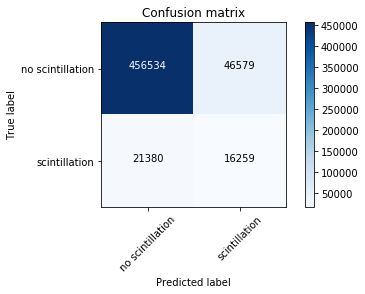

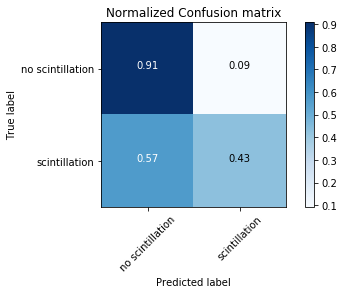

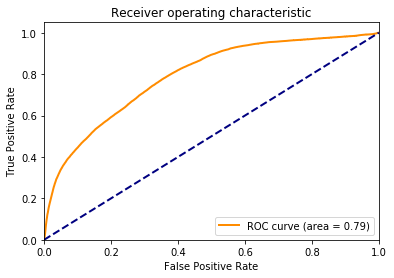

Brier Skill Score = 0.06282007887302957
Total Skill Score = 0.3393905695006647


In [12]:
#### Evaluation Dashboard ####

# INTERACTIVE PLOT OF DATA AND PREDICTIONS
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Initialize Jupyter Notebook mode
init_notebook_mode(connected=True)

idx_ts_plot = [8641,8641+8640]
lw = 2
val_df = interpolated_df.iloc[idx_2016+1:,:].copy(deep=True)
dates = [pd.to_datetime(d) for d in val_df['time'].iloc[idx_ts_plot[0]:idx_ts_plot[-1]]]


data1 = go.Scatter(x=dates, 
                   y = val_df['sigmaPhi projected to vertical at prediction time(1h) [radians]'].iloc[idx_ts_plot[0]:idx_ts_plot[-1]],
                   name='Phase Scintillation Index')


data2 = go.Scatter(x=dates, 
                    y=0.3*y_val_predictions_oneHot[idx_ts_plot[0]:idx_ts_plot[-1]],
                    opacity=0.5,
                    mode="markers",
                    marker = dict(
                      color = 'rgb(252, 61, 33)',   
                      size = 5),
                    name="Model Prediction")
# TODO: plot TP, TN, FP, and FN instead of just the predictions
data3 = go.Scatter(x=dates,
#                    y=np.repeat(thresh_pred,len(y_val_predictions_oneHot[idx_ts_plot[0]:idx_ts_plot[-1]])),
                   y=np.repeat(0.1,len(y_val_predictions_oneHot[idx_ts_plot[0]:idx_ts_plot[-1]])),
                   mode="lines",
                   name="Threshold"
                   )

data_full = [data1,data2,data3]
iplot(data_full)



# Confusion Matrix and ROC Curve
cnfmatrix_class_names = ['no scintillation','scintillation']

cnf_matrix = confusion_matrix(y_val_classify, y_val_predictions_oneHot)

fig1 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cnfmatrix_class_names, normalize=False,
                              title='Confusion matrix')

fig2 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cnfmatrix_class_names, normalize=True,
                              title='Normalized Confusion matrix')

fig3 = plt.figure()
fpr, tpr, thresholds = roc_curve(y_true=y_val_classify, y_score=y_val_predictions, pos_label=1)
    # pos_label indicates the label in the predictions that are 'positive' class
print(fpr, tpr, thresholds)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()


##### SKILL SCORES #####
BSS,TSS,ApSS = calculate_skill_scores(y_val_classify,y_val_predictions,thresh_pred)
    
print('Brier Skill Score = {0}'.format(BSS))
print('Total Skill Score = {0}'.format(TSS))
